# Lab 2a: Kernelization
Support Vector Machines are powerful methods, but they also require careful tuning. We'll explore SVM kernels and hyperparameters on an artificial dataset. We'll especially look at model underfitting and overfitting.

In [2]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

## Getting the data
We fetch the Banana data from OpenML: https://www.openml.org/d/1460  

In [3]:
bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');

C:\Users\Ema\AppData\Local\Temp\ipykernel_32076\3794883227.py:1: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  bananas = oml.datasets.get_dataset(1460) # Banana data has OpenML ID 1460
C:\Users\Ema\AppData\Local\Temp\ipykernel_32076\3794883227.py:2: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = bananas.get_data(target=bananas.default_target_attribute, dataset_format='array');


Quick look at the data:

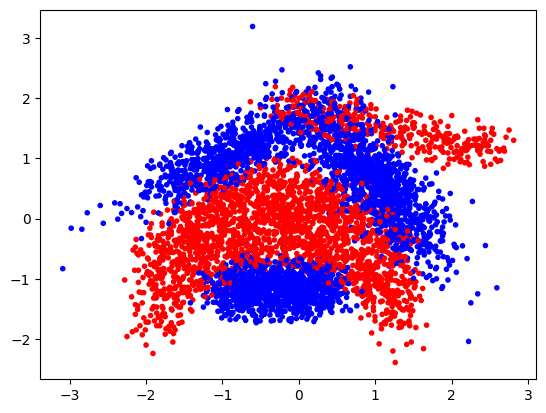

In [4]:
plt.scatter(X[:,0], X[:,1], c=y,cmap=plt.cm.bwr, marker='.');

In [5]:
# Plotting helpers. Based loosely on https://github.com/amueller/mglearn
def plot_svm_kernel(X, y, title, support_vectors, decision_function, dual_coef=None, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border. 
      If the dual coefficients are known (only for kernel SVMs) if paints support vectors with high coefficients darker
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line
    
    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    dual_coef -- The dual coefficients of all the support vectors (not relevant for LinearSVM)
    show -- whether to plot the figure already or not
    """
    # plot the line, the points, and the nearest vectors to the plane
    #plt.figure(fignum, figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    if dual_coef is not None:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], c=dual_coef[0, :],
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    else:
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
                    s=70, edgecolors='k', zorder=10, marker='.', cmap=plt.cm.bwr)
    plt.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-1, 0, 1])
    plt.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    plt.xticks(())
    plt.yticks(())

    if show:
        plt.show()
    
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

## Exercise 1: Linear SVMs

First, we'll look at linear SVMs and the different outputs they produce. Check the [documentation of LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

The most important inputs are:  
* C -- The C hyperparameter controls the misclassification cost and therefore the amount of regularization. Lower values correspond to more regularization
* loss - The loss function, typically 'hinge' or 'squared_hinge'. Squared hinge is the default. Normal hinge is less strict.
* dual -- Whether to solve the primal optimization problem or the dual (default). The primal is recommended if you have many more data points than features (although our datasets is very small, so it won't matter much).

The most important outputs are:  
* decision_function - The function used to classify any point. In this case on linear SVMs, this corresponds to the learned hyperplane, or $y = \mathbf{wX} + b$. It can be evaluated at every point, if the result is positive the point is classified as the positive class and vice versa. 
* coef_ - The model coefficients, i.e. the weights $\mathbf{w}$
* intercept_ - the bias $b$

From the decision function we can find which points are support vectors and which are not: the support vectors are all
the points that fall inside the margin, i.e. have a decision value between -1 and 1, or that are misclassified. Also see the lecture slides.

### Exercise 1.1: Linear SVMs
Train a LinearSVC with C=0.001 and hinge loss. Then, use the plotting function `plot_svm_kernel` to plot the results. For this you need to extract the support vectors from the decision function. There is a hint below should you get stuck. 
Interpret the plot as detailed as you can. Afterwards you can also try some different settings. You can also try using the primal instead of the dual optimization problem (in that case, use squared hinge loss).

C:\Users\Ema\AppData\Local\Temp\ipykernel_32076\3010575611.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


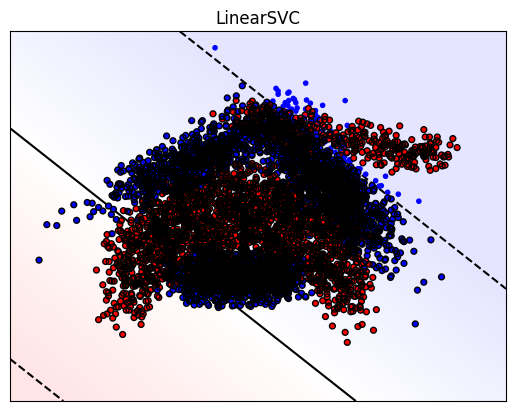

In [6]:
from sklearn.svm import LinearSVC
# Hint: how to compute the support vectors from the decision function (ignore if you want to solve this yourself)
# support_vector_indices = np.where((2 * y - 1) * clf.decision_function(X) <= 1)[0]
# support_vectors = X[support_vector_indices]

# Note that we can also calculate the decision function manually with the formula y = w*X
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]

svc = LinearSVC(C=0.001, loss="hinge").fit(X, y)
# support_vectors = X[np.where((2 * y - 1) * svc.decision_function(X) <= 1)[0]]
# decision_function = lambda X: np.dot(X, svc.coef_[0]) + svc.intercept_[0]
# plot_svm_kernel(X, y, "LinearSVC", support_vectors, decision_function)

plot_svm_kernel(X, y, 'LinearSVC', X[np.where((2 * y - 1) * svc.decision_function(X) <= 1)[0]], svc.decision_function)

## Exercise 2: Kernelized SVMs

Check the [documentation of SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

It has a few more inputs. The most important: 
* kernel - It must be either ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, or your custom defined kernel.
* gamma - The kernel width of the `rbf` (Gaussian) kernel. Smaller values mean wider kernels. 
          Only relevant when selecting the rbf kernel.
* degree - The degree of the polynomial kernel. Only relevant when selecting the poly kernel.

There also also more outputs that make our lifes easier:  
* support_vectors_ - The array of support vectors
* n_support_ - The number of support vectors per class
* dual_coef_ - The coefficients of the support vectors (the dual coefficients)

### Exercise 2.1

Evaluate different kernels, with their default hyperparameter settings.
Outputs should be the 5-fold cross validated accuracy scores for the linear kernel (lin_scores), polynomial kernel (poly_scores) and RBF kernel (rbf_scores). Print the mean and variance of the scores and give an initial interpretation of the performance of each kernel.

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Define kernels to evaluate
kernels = ['linear', 'poly', 'rbf']

# Dictionary to hold the scores
scores = {kernel: {} for kernel in kernels}

# Evaluate each kernel using 5-fold cross-validation
for kernel in kernels:
    svc = SVC(kernel=kernel)
    cv_scores = cross_val_score(svc, X, y, cv=5)
    scores[kernel]['mean'] = cv_scores.mean()
    scores[kernel]['variance'] = cv_scores.var()

# Now, print the mean and variance of the scores for each kernel
for kernel in kernels:
    print(f"{kernel.capitalize()} kernel - Mean accuracy: {scores[kernel]['mean']:.4f}, Variance: {scores[kernel]['variance']:.4f}")

Linear kernel - Mean accuracy: 0.5517, Variance: 0.0000
Poly kernel - Mean accuracy: 0.6377, Variance: 0.0000
Rbf kernel - Mean accuracy: 0.9025, Variance: 0.0001


## Exercise 2: Visualizing the fit
To better understand what the different kernels are doing, let's visualize their predictions.

### Exercise 2.1
Call and fit SVM with linear, polynomial and RBF kernels with default parameter values. For RBF kernel, use kernel coefficient value (gamma) of 2.0. Plot the results for each kernel with "plot_svm_kernel" function. The plots show the predictions made for the different kernels. The background color shows the prediction (blue or red). The full line shows the decision boundary, and the dashed line the margin. The encircled points are the support vectors.

C:\Users\Ema\AppData\Local\Temp\ipykernel_32076\3010575611.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


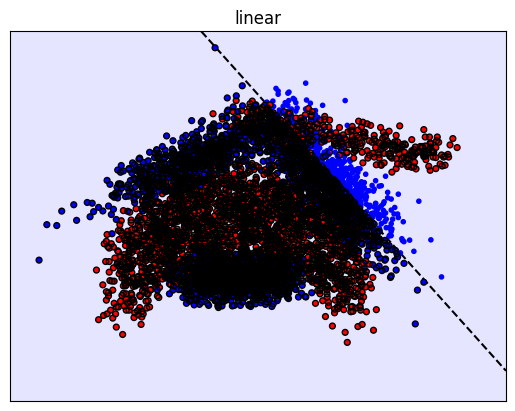

C:\Users\Ema\AppData\Local\Temp\ipykernel_32076\3010575611.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


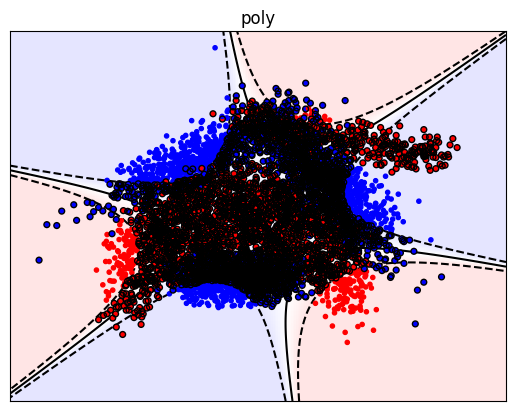

C:\Users\Ema\AppData\Local\Temp\ipykernel_32076\3010575611.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',


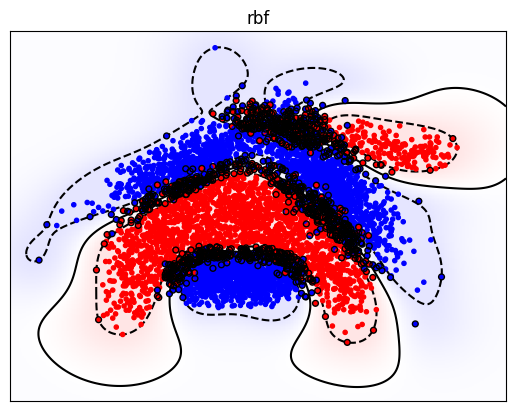

In [8]:
kernels = ['linear', 'poly', 'rbf']
gamma_values = ['auto', 'auto', 2]
models = {kernel: SVC(kernel=kernel, gamma=gamma).fit(X,y) for kernel, gamma in zip(kernels, gamma_values)}
for model in models:
    support_vectors = X[np.where((2 * y - 1) * models[model].decision_function(X) <= 1)[0]]
    plot_svm_kernel(X, y, model, support_vectors, models[model].decision_function)

### Exercise 2.2
Interpret the plots for each kernel. Think of ways to improve the results.

Linear kernel
- The decision boundary is a straight line, suggesting that the SVM is trying to separate the data with a single linear divider.
- The points are color-coded as blue and red, representing the two different classes.
- The dashed lines represent the margins, which are equidistant from the decision boundary. The points that fall on or within these margins are the support vectors, which are circled.
- This model may underfit complex data structures because it only uses a line to separate the classes.


Poly kernel
- The decision boundary has curves, indicating that the polynomial kernel is able to capture more complex patterns in the data.
- Similar to the linear kernel, the points are color-coded by class, and the support vectors are circled.
- The polynomial kernel allows for a more flexible decision boundary, which can lead to better performance on datasets where the relationship between classes is not linear.


RBF kernel
- The decision boundary is highly non-linear and contours around the data points, suggesting that the RBF kernel is capturing the data's intricacies.
- The RBF kernel can create complex regions of class separation, as evidenced by the multiple bulges around clusters of points.
- The color gradient shows the decision function's value, from positive in one class (red) to negative in the other (blue), with lighter areas indicating values closer to the margin.
This kernel is particularly suited for datasets with complex distributions, as it can model non-linear separations.

**Linear**: It's clear that this data is not linearly separable. The linear SVM is badly underfitting. There also appear to be some optimization issues, as the decision boundary lies way outside of the image, and there is a group of non-support vectors that should be support vectors. Forcing more optimization (by decreasing tolerance of the stopping criterion `tol`) yields slightly better results, but will also slow down the optimization (try it of you like).

**Polynomial**: A slightly better fit, but clearly polynomials aren't the best fit either. They divide the space in subspaces that don't capture the banana shapes at all.

**RBF**: Works very nicely, and the default settings seem to actually hit the sweet spot. We should still try to tune C and gamma.

## Exercise 3: Visualizing the RBF models and hyperparameter space
Select the RBF kernel and optimize the two most important hyperparameters (the 𝐶 parameter and the kernel width 𝛾 ).

Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 

### Exercise 3.1
First try 3 very different values for $C$ and $\gamma$ (for instance [1e-3,1,1e3]). For each of the 9 combinations, create the same RBF plot as before to understand what the model is doing. Also create a standard train-test split and report the train and test score. Explain the performance results. When are you over/underfitting? Can you see this in the predictions?

In [9]:
def plot_svm_kernel_adjusted(X, y, title, support_vectors, decision_function, ax, show=True):
    """
    Visualizes the SVM model given the various outputs. It plots:
    * All the data point, color coded by class: blue or red
    * The support vectors, indicated by circling the points with a black border.
    * The decision function as a blue-to-red gradient. It is white where the decision function is near 0.
    * The decision boundary as a full line, and the SVM margins (-1 and +1 values) as a dashed line
    
    Attributes:
    X -- The training data
    y -- The correct labels
    title -- The plot title
    support_vectors -- the list of the coordinates of the support vectores
    decision_function - The decision function returned by the SVM
    ax -- The axes to plot on
    show -- whether to plot the figure already or not
    """
    ax.set_title(title)
    ax.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.bwr, marker='.')
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none',
               s=70, edgecolors='k', zorder=10, marker='.')
    ax.axis('tight')
    x_min, x_max = -3.5, 3.5
    y_min, y_max = -3.5, 3.5

    XX, YY = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
    Z = decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
               levels=[-1, 0, 1])
    ax.pcolormesh(XX, YY, Z, vmin=-1, vmax=1, cmap=plt.cm.bwr, alpha=0.1)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    ax.set_xticks(())
    ax.set_yticks(())

    if show:
        plt.show()

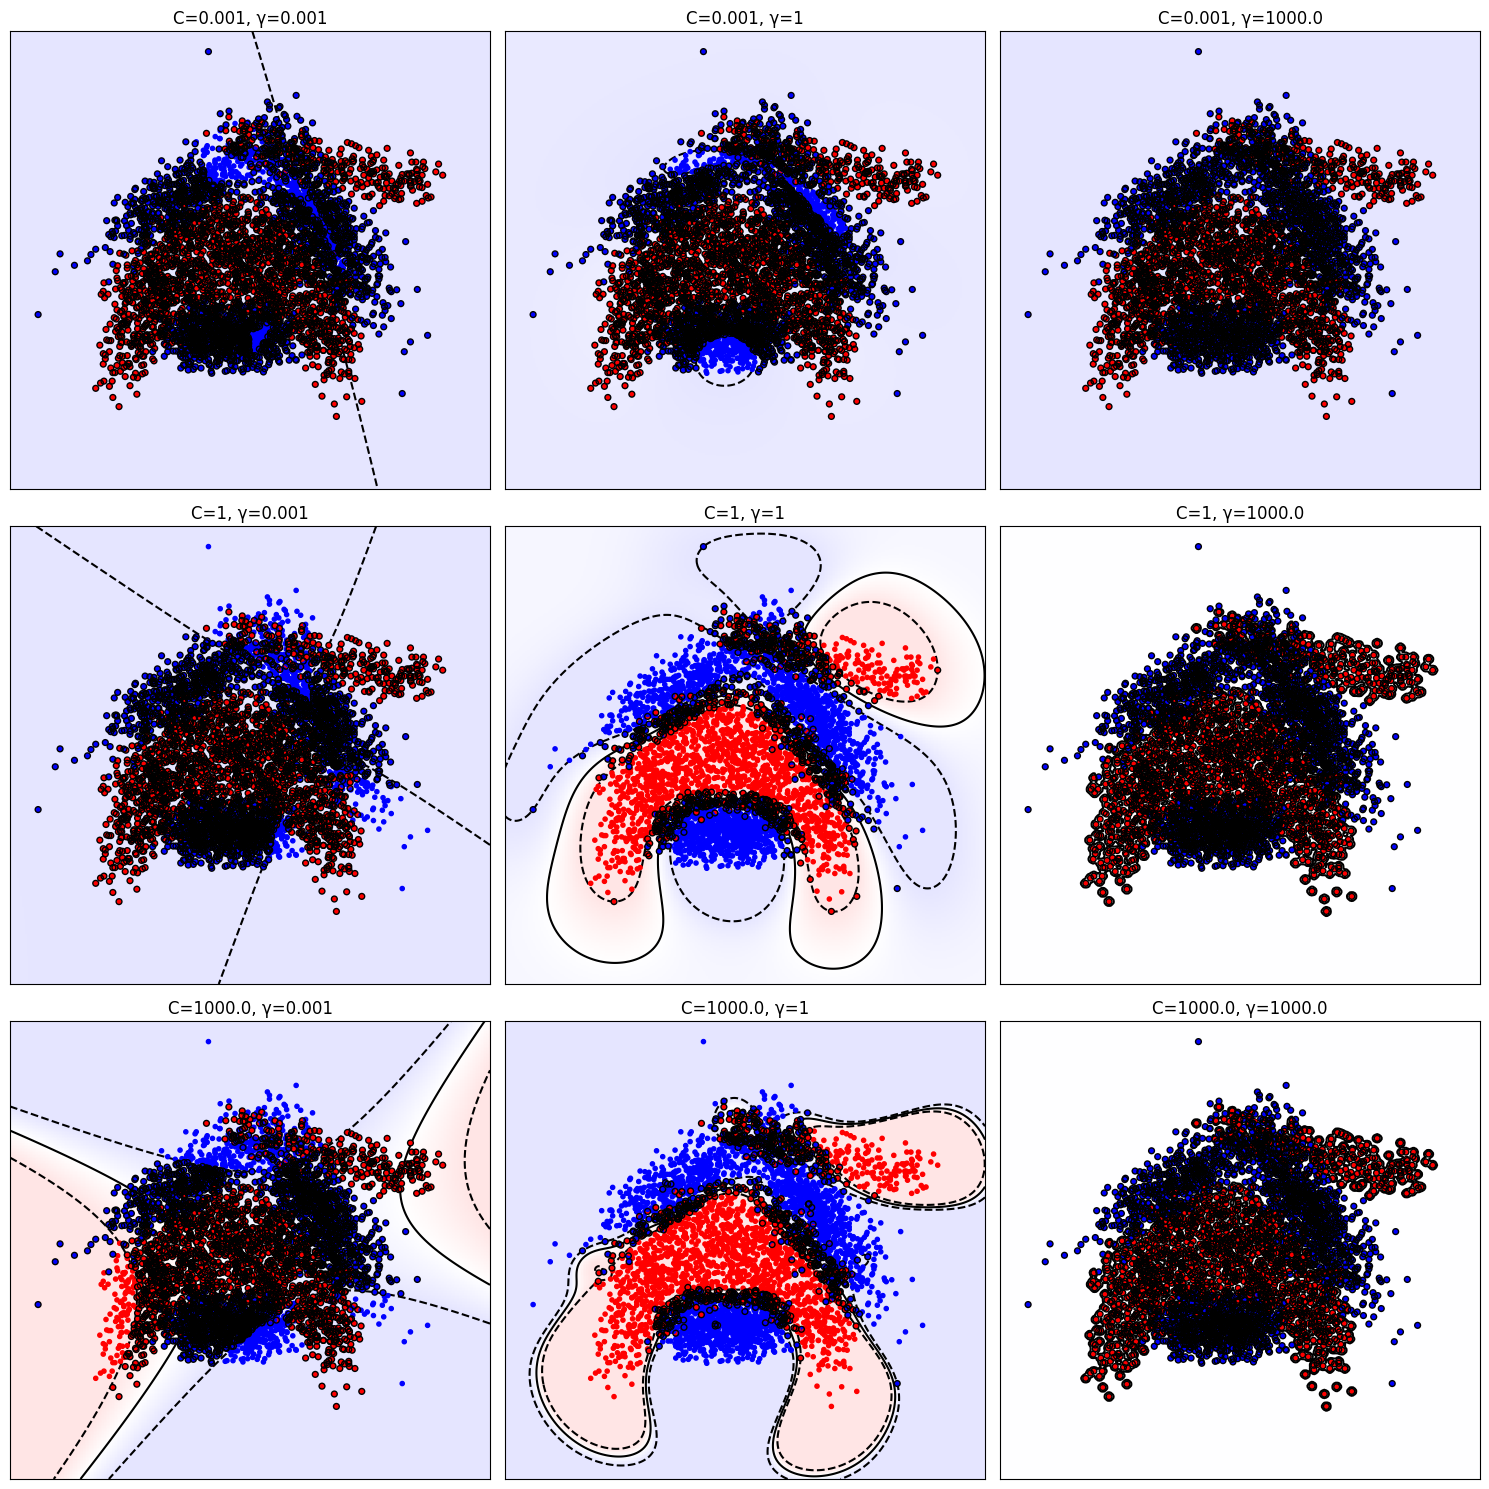

C=0.001, gamma=0.001 -- Train accuracy: 0.5514, Test accuracy: 0.5528
C=0.001, gamma=1 -- Train accuracy: 0.5514, Test accuracy: 0.5528
C=0.001, gamma=1000.0 -- Train accuracy: 0.5514, Test accuracy: 0.5528
C=1, gamma=0.001 -- Train accuracy: 0.5514, Test accuracy: 0.5528
C=1, gamma=1 -- Train accuracy: 0.9104, Test accuracy: 0.9000
C=1, gamma=1000.0 -- Train accuracy: 0.9750, Test accuracy: 0.8547
C=1000.0, gamma=0.001 -- Train accuracy: 0.6460, Test accuracy: 0.6321
C=1000.0, gamma=1 -- Train accuracy: 0.9085, Test accuracy: 0.9009
C=1000.0, gamma=1000.0 -- Train accuracy: 0.9998, Test accuracy: 0.8538


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

C_values = [1e-3,1,1e3]
gamma_values = [1e-3,1,1e3]
scores = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

plot_number = 1
for i, C_value in enumerate(C_values):
    for j, gamma_value in enumerate(gamma_values):
        # Train the model
        model = SVC(kernel='rbf', C=C_value, gamma=gamma_value)
        model.fit(X_train, y_train)

        train_score = accuracy_score(y_train, model.predict(X_train))
        test_score = accuracy_score(y_test, model.predict(X_test))
        scores[(C_value, gamma_value)] = (train_score, test_score)

        support_vectors = model.support_vectors_
        decision_function = model.decision_function
        plot_title = f"C={C_value}, γ={gamma_value}"
        plot_svm_kernel_adjusted(X_train, y_train, plot_title, support_vectors, decision_function, axes[i, j], show=False)

# Adjust layout and display the big plot with all subplots
plt.tight_layout()
plt.show()


for (C_value, gamma_value), (train_score, test_score) in scores.items():
    print(f"C={C_value}, gamma={gamma_value} -- Train accuracy: {train_score:.4f}, Test accuracy: {test_score:.4f}")

- For C = 0.001 (top row), the SVM is always underfitting. The boundaries look very different but all are underfitting because they are over-regularized.
- For gamma = 1000 (narrow Gaussians, right column), almost all datapoints are support vectors, For higher values of C, they are clearly overfitting: the decision boundaries are islands around each point, the model predicts 0 everywhere else. 
- The best results are found for medium C, medium gamma. This also yields the fewest support vectors. The decision boundaries show that it captures the banana shapes well.
- Large C values (bottom row) tend to cause more overfitting unless gamma is very small. These two types of regularization clearly interact with each other.
- For gamma=1, you can also see that the margins for C=1000 are much more narrow than those for C=1. Although not visible in the scores, it is clear that the center model (with the larger margins) will generalize better.

### Exercise 3.2
Optimize the hyperparameters using a grid search, trying every possible combination of C and gamma. Show a heatmap of the results and report the optimal hyperparameter values. Use at least 10 values for $C$ and $\gamma$ in [$2^{-15}..2^{15}$] on a log scale. Report accuracy under 3-fold CV. We recommend to use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and the `heatmap` function defined above. Check their documentation.

In [11]:
C_range = np.logspace(-15, 15, base=2, num=10)
gamma_range = np.logspace(-15, 15, base=2, num=10)

param_grid = {'C': C_range, 'gamma': gamma_range}

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Obtain the scores from the grid search
scores = grid_search.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"The best parameters are C={best_params['C']} and gamma={best_params['gamma']} with a score of {best_score:.4f}")

The best parameters are C=32.0 and gamma=0.3149802624737184 with a score of 0.9047


In [13]:
# Calculate 10% of the initial range
C_range_10_percent = (C_range[-1] - C_range[0]) * 0.1
gamma_range_10_percent = (gamma_range[-1] - gamma_range[0]) * 0.1

# New ranges with the best parameters in the middle
C_zoomed_range = np.logspace(np.log2(best_params['C']) - np.log2(1 + C_range_10_percent),
                             np.log2(best_params['C']) + np.log2(1 + C_range_10_percent), base=2, num=10)
gamma_zoomed_range = np.logspace(np.log2(best_params['gamma']) - np.log2(1 + gamma_range_10_percent),
                                 np.log2(best_params['gamma']) + np.log2(1 + gamma_range_10_percent), base=2, num=10)

# Set up the new parameter grid for GridSearchCV
param_grid_zoomed = {'C': C_zoomed_range, 'gamma': gamma_zoomed_range}

# Perform GridSearchCV with the new grid and 3-fold cross-validation
grid_search_zoomed = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid_zoomed, cv=3)
grid_search_zoomed.fit(X_train, y_train)

# Obtain the scores from the new grid search
scores_zoomed = grid_search_zoomed.cv_results_['mean_test_score'].reshape(len(C_zoomed_range), len(gamma_zoomed_range))

best_params_zoomed = grid_search_zoomed.best_params_
best_score_zoomed = grid_search_zoomed.best_score_
print(f"The zoomed-in best parameters are C={best_params_zoomed['C']} and gamma={best_params_zoomed['gamma']} with a score of {best_score_zoomed:.4f}")


The zoomed-in best parameters are C=17357.688259388844 and gamma=0.128133611851213 with a score of 0.9066


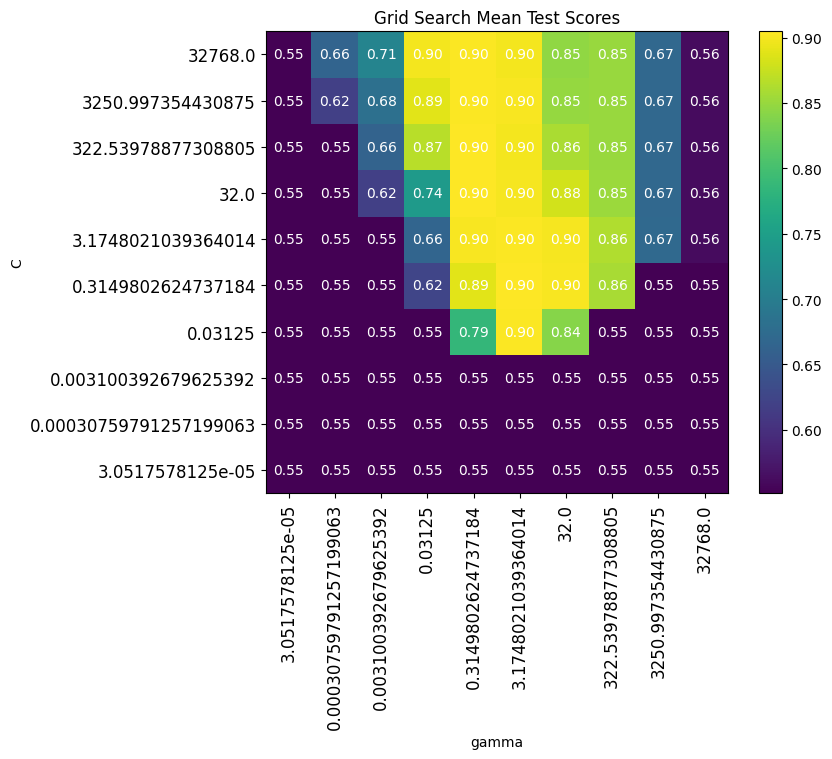

In [14]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    """
    Visualizes the results of a grid search with two hyperparameters as a heatmap.
    Attributes:
    values -- The test scores
    xlabel -- The name of hyperparameter 1
    ylabel -- The name of hyperparameter 2
    xticklabels -- The values of hyperparameter 1
    yticklabels -- The values of hyperparameter 2
    cmap -- The matplotlib color map
    vmin -- the minimum value
    vmax -- the maximum value
    ax -- The figure axes to plot on
    fmt -- formatting of the score values
    """
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)
    
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    for y in range(values.shape[0]):
        for x in range(values.shape[1]):
            ax.text(x + 0.5, y + 0.5, fmt % values[y, x],
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white')

    return img


plt.figure(figsize=(8, 6))
ax = plt.gca()
img = heatmap(scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
              yticklabels=param_grid['C'], cmap="viridis", ax=ax)
plt.title('Grid Search Mean Test Scores')
plt.colorbar(ax.pcolor(scores, cmap="viridis"))
plt.show()

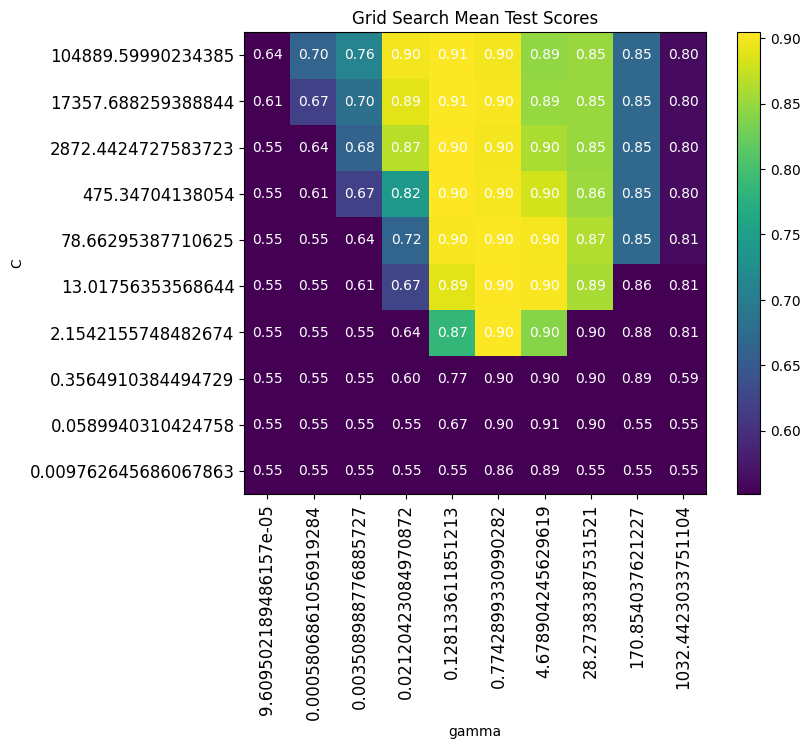

In [15]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
img = heatmap(scores_zoomed, xlabel='gamma', ylabel='C', xticklabels=param_grid_zoomed['gamma'],
              yticklabels=param_grid_zoomed['C'], cmap="viridis", ax=ax)
plt.title('Grid Search Mean Test Scores')
plt.colorbar(ax.pcolor(scores, cmap="viridis"))
plt.show()

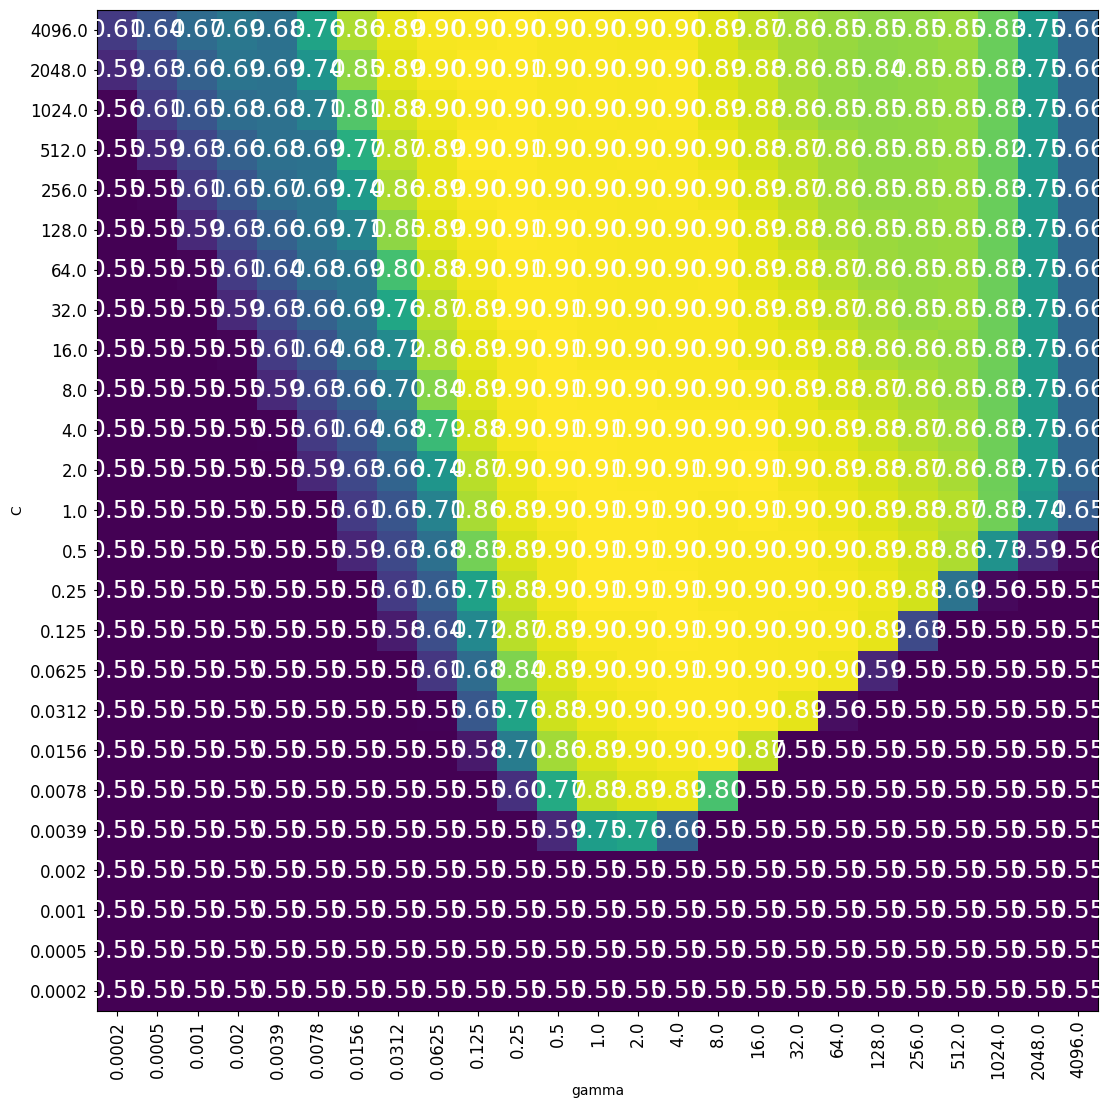

In [16]:
from sklearn import svm
svc = svm.SVC(kernel='rbf')
resolution = 25
param_grid = {'C': np.logspace(-12,12,resolution,base=2),
              'gamma': np.logspace(-12,12,resolution,base=2)}
grid_search = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, scoring='accuracy');
grid_search.fit(X, y);

#Plot with heatmap
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(resolution, resolution)
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1, 1, figsize=(13, 13))
heatmap(scores, xlabel='gamma', xticklabels=np.around(param_grid['gamma'],4),
                      ylabel='C', yticklabels=np.around(param_grid['C'],4), cmap="viridis", fmt="%.2f", ax=axes);

We can see that there isn't really an simple optimal peak in the C-gamma space, but rather a 'ridge' of optimal performance. For instance, (gamma=0.25, C=4096) has top performance, 
but so does (gamma=2.0, C=0.25).